In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image

from datetime import datetime
import glob
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
import os

from unet_model import *
from data_prep import *

# %load_ext tensorboard

tf.__version__

'2.3.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_logical_devices('GPU')
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Model

## Load Model

In [8]:
model_name = "20200831-032132_lr001/"
model = keras.models.load_model("saved_models/"+model_name)

## Declare, Compile, and Train UNet Model

In [6]:
# To train only one model at a time. To train multiple in a row, run train_mult_models script

learning_rate = 0.001
print("Training with learning rate: " + str(learning_rate))

train_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr" + str(learning_rate).split('.')[1]
logdir = "logs/" + train_name
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = unet_model((512,512,1))
# model.summary()

opt = keras.optimizers.Adam(learning_rate=learning_rate) # default is 0.001
model.compile(optimizer = opt, loss="binary_crossentropy", metrics=["accuracy"])

# create_generators
seed = 1
batchsize = 2

train_generator, val_generator = create_generators(seed=seed, batchsize=batchsize)
# train_generator, val_generator = create_generators("tranformed_val", seed=seed, batchsize=batchsize)

epochs = 50

# history = model.fit(x=X_train, y=Y_train, epochs=30, batch_size=1)

history = model.fit(
    train_generator,
    steps_per_epoch=24/batchsize, # TODO: fix this #TODO: check that mult by 10 reduces number of epochs to get to same thing 
    validation_data=val_generator,
    validation_steps=6/batchsize, # TODO: fix this
    epochs=epochs,
    verbose=1
    callbacks=[tensorboard_callback]
)

os.makedirs("saved_models/"+train_name+"/")
model.save("saved_models/"+train_name+"/")

# tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()

Training with learning rate: 0.001
Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Creating val_image_datagen and val_mask_datagen
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [9]:
train_generator

TypeError: 'zip' object is not subscriptable

# Visualize Predictions

## Training Set

In [130]:
train_img_to_compare = 0 # Be careful and make sure you know which images are in temp_train_val_split

train_img = image.load_img("data/temp_train_val_split/train_image/{}.png".format(train_img_to_compare))
true_train_mask = image.load_img("data/temp_train_val_split/train_mask/{}.png".format(train_img_to_compare))

pred_train_mask = model.predict(np.expand_dims(image.img_to_array(train_img)[:,:,0:1]/255.0, axis=0))
pred_train_mask = (pred_train_mask[0,:,:,0] > 0.5).astype(int)

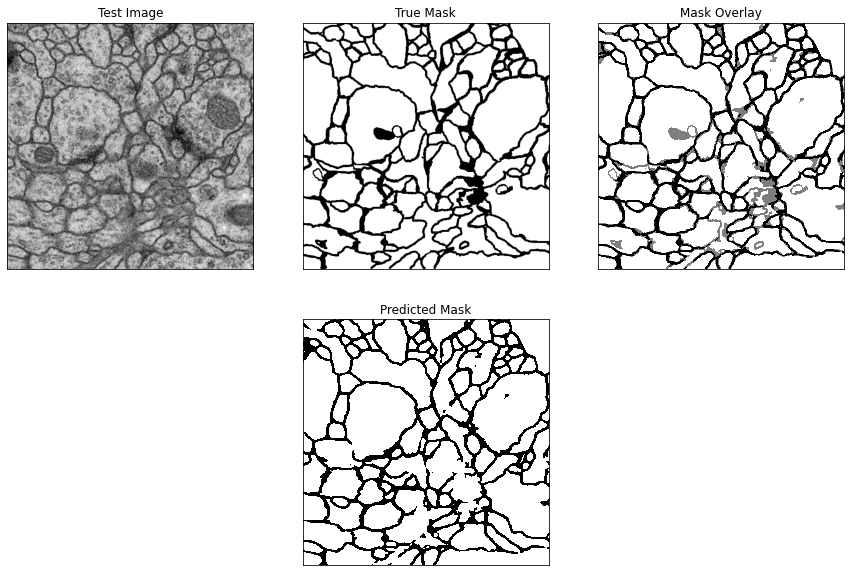

In [184]:

fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2,3)
fig.set_size_inches(15, 10)

ax11.imshow(train_img, cmap="ocean")
ax11.set_title("Test Image")
ax11.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax12.imshow(true_train_mask)
ax12.set_title("True Mask")
ax12.tick_params(left=False, bottom=False,  labelleft=False, labelbottom=False)


ax13.imshow(image.img_to_array(true_train_mask)[:,:,0]/255.0, cmap="gray", interpolation="none")
ax13.imshow(pred_train_mask, cmap="bone", alpha=0.5, interpolation="none")
ax13.set_title("Mask Overlay")
ax13.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax21.axis("off")

ax22.imshow(pred_train_mask, cmap="gray", interpolation="none") # need to only get one channel, otherwise cmap is ignored
ax22.set_title("Predicted Mask")
ax22.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax23.axis("off");


## Dev Set

In [163]:
dev_image_to_compare = 1 # Be careful here as well!

dev_image = image.load_img("data/temp_train_val_split/val_image/{}.png".format(dev_image_to_compare))
true_dev_mask = image.load_img("data/temp_train_val_split/val_mask/{}.png".format(dev_image_to_compare))

pred_dev_mask = model.predict(np.expand_dims(image.img_to_array(dev_image)[:,:,0:1]/255.0, axis=0))
pred_dev_mask = (pred_dev_mask[0,:,:,0] > 0.5).astype(int)

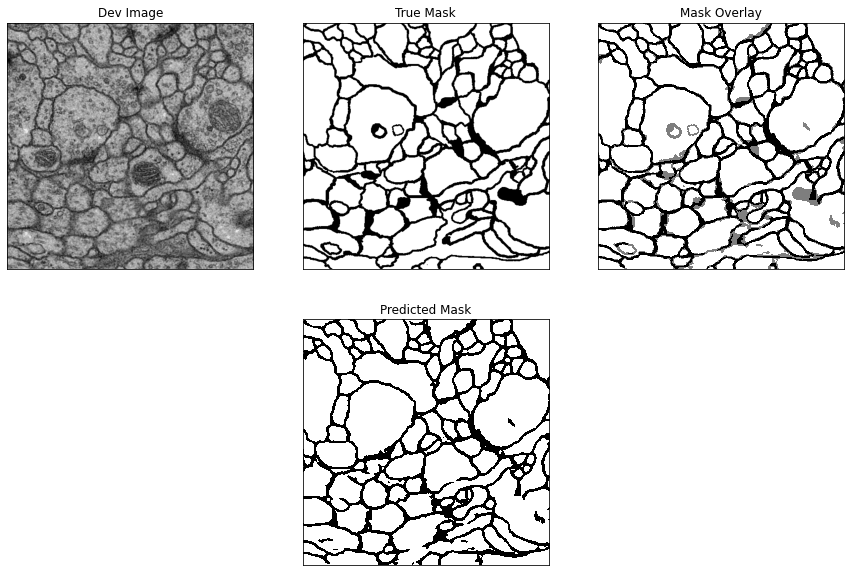

In [183]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2,3)
fig.set_size_inches(15, 10)

ax11.imshow(dev_image, cmap="ocean")
ax11.set_title("Dev Image")
ax11.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax12.imshow(true_dev_mask)
ax12.set_title("True Mask")
ax12.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax21.axis("off")

ax22.imshow(pred_dev_mask, cmap="gray", interpolation="none") # need to only get one channel, otherwise cmap is ignored
ax22.set_title("Predicted Mask")
ax22.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax13.imshow(image.img_to_array(true_dev_mask)[:,:,0]/255.0, cmap="gray", interpolation="none")
ax13.imshow(pred_dev_mask, cmap="bone", alpha=0.5, interpolation="none")
ax13.set_title("Mask Overlay")
ax13.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax23.axis("off");

## Test Set

### Save predicted segmentations of test set

In [178]:
save_to = "data/test_set/predictions/"+model_name
os.makedirs(save_to)

for f in os.listdir("data/test_set/images/"):
    img_path = "data/test_set/images/" + f
    img = image.load_img(img_path)
    x = image.img_to_array(img)[:,:,0:1]
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    predicted = model.predict(x)    
    rescaled = ((predicted[0,:,:,0]>0.5) * 255).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(save_to+f)

### Look at predictions

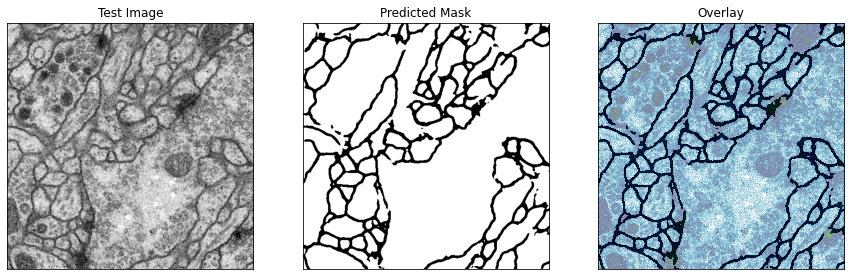

In [111]:
img_to_compare = 0
test_img = image.load_img("data/test_set/images/{}.png".format(img_to_compare))
img_mask = image.load_img("data/test_set/predictions/20200831-032132_lr001/{}.png".format(img_to_compare))

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(15, 10)

ax1.imshow(test_img, cmap="ocean")
ax1.set_title("Test Image")
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax2.imshow(img_mask)
ax2.set_title("Predicted Mask")
ax2.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax3.imshow(image.img_to_array(test_img)[:,:,0]/255.0, cmap="ocean", interpolation="none") # need to only get one channel, otherwise cmap is ignored
ax3.imshow(image.img_to_array(img_mask)[:,:,0]/255.0, cmap="gray", alpha=0.5, interpolation="none")
ax3.set_title("Overlay")
ax3.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

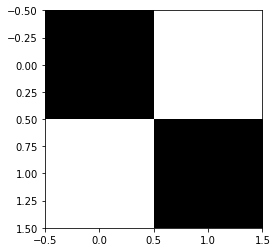

In [160]:
# a reminder on how colors appear in gray cmap
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# imshow([[0,1],[1,0]], cmap="gray", vmin=0, vmax=1)

## Analyze Loss and Accuracy

This only works when you run a model in this notebook.<br>
Doesn't make sense to run this sense one can use TensorBoard (see logs directory)

In [179]:
# print(history.history.keys())
# # print(history.history['loss'])
# loss = history.history['loss']
# acc = history.history['accuracy']

# val_loss = history.history['val_loss']
# val_acc = history.history['val_accuracy']

In [181]:
# fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

# fig.set_size_inches(15, 10)

# ax11.plot(range(1,epochs+1), loss)
# ax11.plot(range(1,epochs+1), val_loss)
# ax11.set_title('Loss')
# ax11.set_xlabel("Epoch")
# ax11.set_ylabel("Loss");
# ax11.set_ylim(0,1)
# ax11.legend(['acc', 'val_acc'])

# ax12.plot(range(1,epochs+1), acc)
# ax12.plot(range(1,epochs+1), val_acc)
# ax12.set_title('Accuracy')
# ax12.set_xlabel("Epoch")
# ax12.set_ylabel("Percentage");
# ax12.set_ylim(0,1);
# ax12.legend(['acc', 'val_acc'])

# ax21.plot(range(1,epochs+1), loss)
# ax21.plot(range(1,epochs+1), val_loss)
# ax21.set_title('Loss')
# ax21.set_xlabel("Epoch")
# ax21.set_ylabel("Loss");
# ax21.legend(['loss', 'val_loss'])

# ax22.plot(range(1,epochs+1), acc)
# ax22.plot(range(1,epochs+1), val_acc)
# ax22.set_title('Accuracy')
# ax22.set_xlabel("Epoch")
# ax22.set_ylabel("Percentage")
# ax22.legend(['acc', 'val_acc'])